In [1]:
# UFF implementation of bonded and nonbonded interactions
# Parameters are obtained from OpenBabel: $http://glyco3d.cermav.cnrs.fr/jmol/jsmol/j2s/JM/FF/data/UFF.txt
# Implementations are found here: $https://github.com/rdkit/rdkit/tree/157df3c2967ce2949b68ea3fed5d46b767484b17/Code/ForceField/UFF

include("./UFF.jl")
using .UFF

using CSV
using DataFrames
uff_params = CSV.read("UFF.csv", DataFrame)

,Atom,r1,theta0,x1,D1,zeta,Z1,Vi,Uj
,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,param H_,0.354,180.0,2.886,0.044,12.0,0.712,0.0,0.0
2,param H_b,0.46,83.5,2.886,0.044,12.0,0.712,0.0,0.0
3,param He4+4,0.849,90.0,2.362,0.056,15.24,0.098,0.0,0.0
4,param Li,1.336,180.0,2.451,0.025,12.0,1.026,0.0,2.0
5,param Be3+2,1.074,109.47,2.745,0.085,12.0,1.565,0.0,2.0
6,param B_3,0.838,109.47,4.083,0.18,12.052,1.755,0.0,2.0
7,param B_2,0.828,120.0,4.083,0.18,12.052,1.755,0.0,2.0
8,param C_3,0.757,109.47,3.851,0.105,12.73,1.912,2.119,2.0
9,param C_R,0.729,120.0,3.851,0.105,12.73,1.912,0.0,2.0


In [2]:
# Generate all parameters in a single thread for a given system size

function gen_all_parameters(set_size)
    curr_parameter = nothing
    for i=1:set_size
        atom1 = uff_params[i,:]
        for j=i:set_size
            atom2 = uff_params[j,:]
            curr_parameter = bond_energy(3,1,atom1,atom2)
            curr_parameter = dihedral_energy(1,atom1,atom2,true,true,3,pi,1)
            curr_parameter = electrostatic_energy(1,1,1)
            curr_parameter = vdw_energy(7,atom1,atom2)
        end
    end
    for j=1:set_size
        atom2 = uff_params[j,:]
        for i=1:set_size
            atom1 = uff_params[i,:]
            for k=i:set_size
                atom3 = uff_params[k,:]
                curr_parameter = angle_energy(20*pi/180,atom1,atom2,atom3,1,1,0)
            end
        end
    end
end
@time gen_all_parameters(128)

  3.726198 seconds (104.67 M allocations: 1.630 GiB, 9.75% gc time, 7.66% compilation time)


In [3]:
Threads.nthreads()

4

In [4]:
# Generate all parameters in multiple threads for a given system size

function gen_all_parameters_threaded(set_size)
    curr_parameter = nothing
    Threads.@threads for i=1:set_size
        atom1 = uff_params[i,:]
        for j=i:set_size
            atom2 = uff_params[j,:]
            curr_parameter = bond_energy(3,1,atom1,atom2)
            curr_parameter = dihedral_energy(1,atom1,atom2,true,true,3,pi,1)
            curr_parameter = electrostatic_energy(1,1,1)
            curr_parameter = vdw_energy(7,atom1,atom2)
        end
    end
    Threads.@threads for j=1:set_size
        atom2 = uff_params[j,:]
        for i=1:set_size
            atom1 = uff_params[i,:]
            for k=i:set_size
                atom3 = uff_params[k,:]
                curr_parameter = angle_energy(20*pi/180,atom1,atom2,atom3,1,1,0)
            end
        end
    end
end
@time gen_all_parameters_threaded(128)

  1.269415 seconds (104.16 M allocations: 1.604 GiB, 27.02% gc time, 5.36% compilation time)


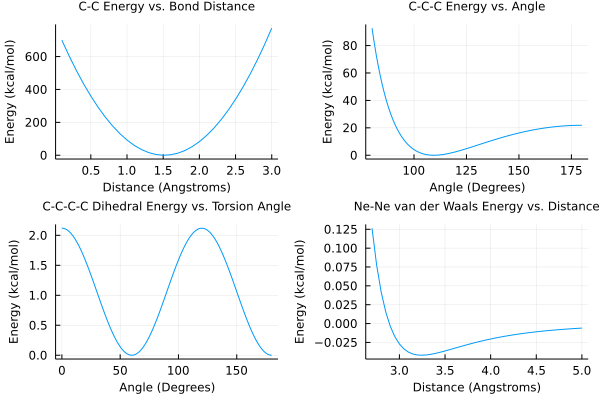

In [5]:
# Plot examples of energy functions

using Plots

function get_atom(atom_name)
    atom_idx = findall(x->x=="param " * atom_name,uff_params[:,1])[1]
    return uff_params[atom_idx,:]
end

atom1 = get_atom("C_3")
atom2 = get_atom("C_3")

xvals = 0.1:0.1:3
yvals = [bond_energy(i,1,atom1,atom2) for i in xvals]
p1 = plot(xvals, yvals, title="C-C Energy vs. Bond Distance", xlabel="Distance (Angstroms)", ylabel="Energy (kcal/mol)", legend=false)

atom1 = get_atom("C_3")
atom2 = get_atom("C_3")
atom3 = get_atom("C_3")
xvals = 80:1:180
yvals = [angle_energy(i*pi/180,atom1,atom2,atom3,1,1,0) for i in xvals]
p2 = plot(xvals, yvals, title="C-C-C Energy vs. Angle", xlabel="Angle (Degrees)", ylabel="Energy (kcal/mol)", legend=false)

atom2 = get_atom("C_3")
atom3 = get_atom("C_3")
xvals = 0:1:180
yvals = [dihedral_energy(i*pi/180,atom2,atom3,true,true,3,pi,1) for i in xvals]
p3 = plot(xvals, yvals, title="C-C-C-C Dihedral Energy vs. Torsion Angle", xlabel="Angle (Degrees)", ylabel="Energy (kcal/mol)", legend=false)

atom1 = get_atom("Ne4+4")
atom2 = get_atom("Ne4+4")
xvals = 2.7:0.05:5
yvals = [vdw_energy(i,atom1,atom2) for i in xvals]
p4 = plot(xvals, yvals, title="Ne-Ne van der Waals Energy vs. Distance", xlabel="Distance (Angstroms)", ylabel="Energy (kcal/mol)", legend=false)

l = @layout [a b; c d]
p_all = plot(p1, p2, p3, p4, layout = l, titlefontsize=8, labelfontsize=8,dpi=300)
#png(p_all, "/Users/narunach/Downloads/energy_functions.png")
p_all

In [6]:
# Explicitly calculate the energy of a butane molecule from carbon coordinates

using LinearAlgebra

function get_butane_energy(coords_len_12)
    function angle(a, b)
        return acos(clamp(a⋅b/(norm(a)*norm(b)), -1, 1))
    end

    atom1 = get_atom("C_3")
    atom2 = get_atom("C_3")
    atom3 = get_atom("C_3")
    atom4 = get_atom("C_3")
    
    a1_coords = coords_len_12[1:3]
    a2_coords = coords_len_12[4:6]
    a3_coords = coords_len_12[7:9]
    a4_coords = coords_len_12[10:12]
    
    dist_12 = sqrt(sum((a2_coords - a1_coords).^2))
    dist_23 = sqrt(sum((a3_coords - a2_coords).^2))
    dist_34 = sqrt(sum((a4_coords - a3_coords).^2))
    dist_14 = sqrt(sum((a4_coords - a1_coords).^2))
    angle_123 = angle(a1_coords-a2_coords, a3_coords-a2_coords)
    angle_234 = angle(a2_coords-a3_coords, a4_coords-a3_coords)
    b1 = a2_coords - a1_coords
    b2 = a3_coords - a2_coords
    b3 = a4_coords - a3_coords
    phi = angle(cross(b1,b2),cross(b2,b3))
    #println(phi*180/pi)
    
    stretch_contrib = bond_energy(dist_12, 1, atom1, atom2) + bond_energy(dist_23, 1, atom2, atom3) + bond_energy(dist_34, 1, atom3, atom4)
    angle_contrib = angle_energy(angle_123, atom1, atom2, atom3, 1, 1, 0) + angle_energy(angle_234, atom2, atom3, atom4, 1, 1, 0)
    torsion_contrib = dihedral_energy(phi, atom2, atom3, true, true, 3, pi, 1)
    vdw_contrib = vdw_energy(dist_14, atom1, atom4)
    
    total_energy = stretch_contrib + angle_contrib + torsion_contrib + vdw_contrib
    return total_energy
end

# From pre_optimized.xyz
coords_init = [-5.39216, 0.09577, 0.00000, -3.65480, 1.58545, 0.00000, -1.43014,1.39392,0.00000,-0.13772,-0.01064,0.00000]

# From post_optimized.xyz
coords_end = [-3.95543,1.49868,1.37463,-3.08101,2.29277,0.40401,-1.61255,1.83936,0.39627,-1.42295,0.40748,-0.10478]

# Print energies in kcal/mol
println(get_butane_energy(coords_init))
println(get_butane_energy(coords_end))

467.60952885456555
1.7675499255346983


In [7]:
# Find a globally optimal structure

using Optim
res = optimize(get_butane_energy, coords_init)

 * Status: success

 * Candidate solution
    Final objective value:     -1.045426e-01

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    911
    f(x) calls:    1521


In [8]:
get_butane_energy(Optim.minimizer(res))

-0.10454262683155913

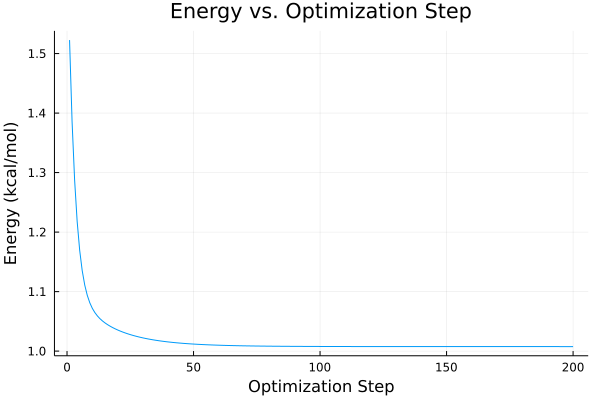

In [9]:
# Find a locally optimal structure using ForwardDiff gradients

using ForwardDiff

energies = zeros(200)

coords_optim = coords_end
for i=1:200
    d_coord = ForwardDiff.gradient(get_butane_energy, coords_optim)
    coords_optim = coords_optim - 0.001*d_coord
    #println(get_butane_energy(coords_optim))
    energies[i] = get_butane_energy(coords_optim)
end

opt_plot = plot(1:200,energies,title="Energy vs. Optimization Step", ylabel="Energy (kcal/mol)", xlabel="Optimization Step", legend=false, dpi=300)
#png(opt_plot,"/Users/narunach/Downloads/opt_plot.png")
opt_plot